In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

## 0. Problem setting

In [2]:
n = 10
kl = [i+1 for i in range(5)]
setting = {k: {"A":[], "b":np.empty(n)} for k in kl}

In [3]:
A_od = [[0 for j in range(n)] for i in range(n)]
for i in range(n):
    for j in range(n):
        m = min(i,j)+1
        M = max(i,j)+1
        A_od[i][j] = np.exp(m/M) * np.cos(m*M)

for i in range(n):
    A_od[i][i] = 0
    
A_od = np.array(A_od)

In [4]:
A_od_rowsum = A_od.sum(axis = 1)

In [5]:
for k in kl:
    # 1. A_k
    setting[k]["A"] = A_od * np.sin(k)
    for i in range(n):
        setting[k]["A"][i][i] = ((i+1)/10)*abs(np.sin(k)) + A_od_rowsum[i]*np.sin(k)
    # 2. b_k
    for i in range(n):
        setting[k]["b"][i] = np.exp((i+1)/k) * np.sin((i+1)*k)

In [6]:
def maxquad(x = np.zeros(n), setting = setting):
    val = np.zeros(len(kl))
    for k in kl:
        A = setting[k]["A"]
        b = setting[k]["b"]
        val[k-1] = np.matmul(np.matmul(x, A), x) - np.dot(b, x)
    return (max(val), np.argmax(val), val)

In [7]:
def grad(x=np.zeros(n), A=np.zeros(n*n), b=np.zeros(n)):
    return 2*np.matmul(A, x)-b

In [8]:
def SGD(x0, T=100, tol=1, version="vanilla", globalmin = 0):
    history = {"x":[], "k":[], "f":[], "bestf":[]}
    minf = 10**5
    minx = np.zeros(n)
    mink = -1
    xt = x0
    if version=="vanilla":
        C = 1
        for t in range(1, T):
            ##### OBTAIN maxquad #####
            fx, kt, _ = maxquad(xt) # the real $k$ is kt+1.
            history["x"].append(xt)
            history["f"].append(fx)
            history["k"].append(kt)
            if fx < minf:
                minx = xt
                minf = fx
                mink = kt
                history["bestf"].append(fx)
            else:
                history["bestf"].append(minf)
#             print(t, xt, fx, kt)
            
            ##### SGD UPDATE #####
            lr = C/(t**0.5)
            g = grad(xt, setting[kt+1]["A"], setting[kt+1]["b"]) # note: any gradient obtained by $A_k, b_k$ is subgradient.
            ng = g / np.linalg.norm(g) # asusme the norm is nonzero
            xt = xt - lr * ng
                
    if version=="polyak":
        C = 1
        for t in range(1, T):
            ##### OBTAIN maxquad #####
            fx, kt, _ = maxquad(xt) 
            history["x"].append(xt)
            history["f"].append(fx)
            history["k"].append(kt)
            if fx < minf:
                minx = xt
                minf = fx
                mink = kt
                history["bestf"].append(fx)
            else:
                history["bestf"].append(minf)
#             print(t, fx, kt)
            
            ##### SGD UPDATE #####
            g = grad(xt, setting[kt+1]["A"], setting[kt+1]["b"])
            norm = np.linalg.norm(g)
#             print(norm)
            lr = (fx - globalmin)/norm 
            ng = g / norm
            xt = xt - lr * ng
    
    return (minf, minx, mink, history)

## (a)

What is $f(x^1)$?

In [9]:
f_x1, _, _  =maxquad(np.ones(n))
print(f_x1)

5250.524414597696


What is $min_{x\in\mathbb{R}^d} f(x)$?

In [10]:
horizon = 10**5
minf, minx, mink, history = SGD(np.ones(n), T=horizon)

In [11]:
minf

-134.98645619766074

## (b)

In [12]:
end = int(horizon * 0.8)
gap = np.log(np.array(history["bestf"][:end])-minf)
iterno = np.log(np.array(range(1,end+1)))

Text(0, 0.5, 'Suboptimality Gap (log-scale)')

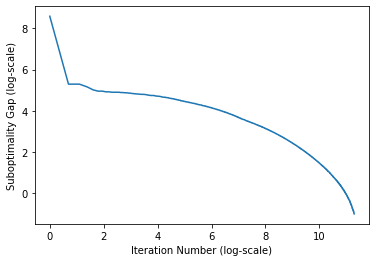

In [13]:
plt.plot(iterno, gap, label="Vanilla stepsize")
plt.xlabel('Iteration Number (log-scale)')
plt.ylabel('Suboptimality Gap (log-scale)')

## (c)

In [14]:
horizon = 10**5
minf_p, minx_p, mink_p, history_p = SGD(np.ones(n), T=horizon, version="polyak", globalmin = minf)

In [15]:
minf_p

-134.98471126065186

In [16]:
end = int(horizon * 0.8)
gap_p = np.log(np.array(history_p["bestf"][:end])-minf)

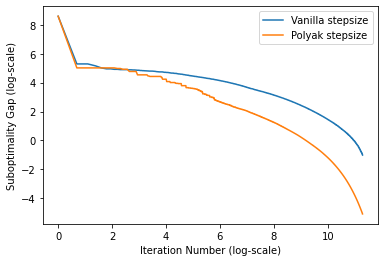

In [17]:
plt.plot(iterno, gap, label="Vanilla stepsize")
plt.plot(iterno, gap_p, label="Polyak stepsize")
plt.xlabel('Iteration Number (log-scale)')
plt.ylabel('Suboptimality Gap (log-scale)')
plt.legend()